In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import numpy as np

from sklearn.datasets import make_moons

from tqdm.auto import trange

from loss import fff_loss
from models import resnet
import distributions as d

device = "cpu"

In [11]:
n_steps = 10000
batch_size = 1024
noise = 0.1
beta = 100.

In [12]:
encoder = resnet(n_dim=2, hidden_dim=128, n_blocks=3, output_dim=2)
decoder = resnet(n_dim=2, hidden_dim=128, n_blocks=3, output_dim=3)
optim = torch.optim.Adam([*encoder.parameters(), *decoder.parameters()], lr=2e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=1e-3,total_steps=n_steps)
moons_dist = d.moons_distribution()

loss_history = []
with trange(n_steps) as pbar:
    for step in pbar:
        optim.zero_grad()
        batch, _ = make_moons(batch_size, noise=noise)
        x = torch.from_numpy(batch).float().to(device)
        #log_probs = moons_dist.log_prob(x).float().to(device)
        #x = torch.cat((x, log_probs[:, None]), dim=-1)
        
        loss = fff_loss(x=x, encode=encoder, decode=decoder, beta=beta, fff_loss_dims=2)
        loss.mean().backward()
        optim.step()
        scheduler.step()
        
        loss_history.append(loss.mean().detach().numpy())

  0%|          | 0/10000 [00:00<?, ?it/s]

 51%|█████▏    | 5136/10000 [10:31:20<23:13,  3.49it/s]         

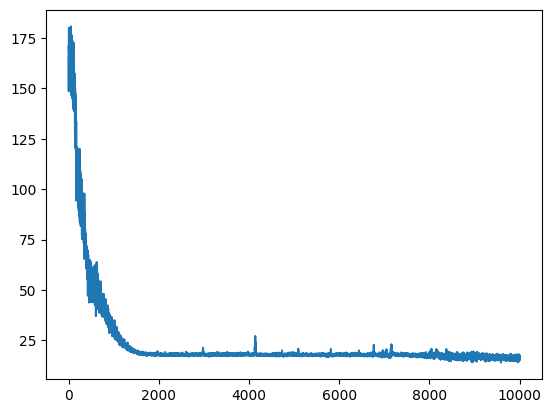

In [5]:
plt.plot(loss_history)

tensor([-1.3932, -7.0781, -0.8445, -2.1989, -2.3564, -1.9068, -1.5722, -3.4024,
        -2.4356, -0.5745], dtype=torch.float64, grad_fn=<SliceBackward0>)
tensor([ 0.2797,  0.3671, -0.1104,  0.1834,  0.2771,  0.4062,  0.3021,  0.2711,
         0.2377,  0.2953], grad_fn=<SelectBackward0>)


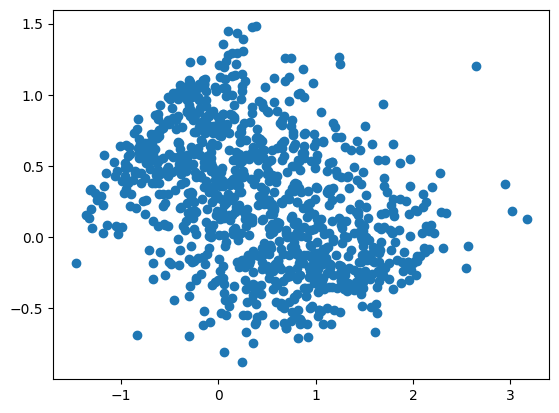

In [8]:
z = torch.randn(1000, 2, device=device)
x_samples = decoder(z)
log_probs = moons_dist.log_prob(x_samples[:,:2])
print(log_probs[:10])
print(x_samples[:10,2])

plt.scatter(x_samples[:,0].detach().numpy(), x_samples[:,1].detach().numpy())
